In [1]:
import sqlite3
import logging
import pandas as pd
from urllib.parse import urlparse
from tld import get_tld, get_fld
from matplotlib import pyplot as plt
from http.cookies import SimpleCookie

plt.rcParams['figure.figsize'] = [20, 10]


In [2]:
# Specify your local path to the sqlite db containing crawl data
SQLITE_LOCAL_PATH = '/Users/liam/dev/OpenWPM/data/gemeente_social_complete.sqlite'
SM_FLDS = ['facebook', 'instagram', 'linkedin', 'google', 'youtube', 'twitter']

In [3]:
# Read sqlite query results into a pandas DataFrame
con = sqlite3.connect(SQLITE_LOCAL_PATH)

cursor = con.cursor()

# Parse javascript table from SQLite
javascript = pd.read_sql_query("SELECT * from javascript", con)
# Parse SITE_VISITS table from SQLite
site_visits = pd.read_sql_query("SELECT * from site_visits", con)

In [4]:
# Get a sense for columns
print(javascript.columns)
print(site_visits.columns)

#Does this add up...
#print(site_visits.count())

#Drop what we don't need

javascript = javascript.drop(["script_loc_eval", "page_scoped_event_ordinal", "event_ordinal", "id", "incognito", "frame_id", "script_line", "script_col", "crawl_id", "extension_session_uuid", "tab_id", "window_id"], axis=1)

# Let's start by looking only at the visits to the parent urls (i.e. the gemeente sites themselves)
gemeente_site_visits = site_visits.loc[site_visits['parent_url'] == site_visits['site_url']]
#print(gemeente_site_visits.count())

# Now narrow down the javascript dataframe to only visit_ids from parent_urls, and let's join the visit_url to the javascript
gemeente_visit_ids = gemeente_site_visits['visit_id']

gemeente_javascript = javascript.loc[javascript['visit_id'].isin(gemeente_visit_ids)]
#print(gemeente_javascript.count())

# Join the site_visits information into the javascript for a complete dataset and we can select columns next
all_columns = gemeente_javascript.set_index('visit_id').join(gemeente_site_visits.set_index('visit_id'), lsuffix='_javascript', rsuffix='_site_visits')

# This should be equal to javascript.columns + site_vists.columns anything that was identical now has suffixes
all_columns.columns

Index(['id', 'incognito', 'crawl_id', 'visit_id', 'extension_session_uuid',
       'event_ordinal', 'page_scoped_event_ordinal', 'window_id', 'tab_id',
       'frame_id', 'script_url', 'script_line', 'script_col', 'func_name',
       'script_loc_eval', 'document_url', 'top_level_url', 'call_stack',
       'symbol', 'operation', 'value', 'arguments', 'time_stamp'],
      dtype='object')
Index(['visit_id', 'crawl_id', 'site_url', 'parent_url'], dtype='object')


Index(['script_url', 'func_name', 'document_url', 'top_level_url',
       'call_stack', 'symbol', 'operation', 'value', 'arguments', 'time_stamp',
       'crawl_id', 'site_url', 'parent_url'],
      dtype='object')

In [5]:
# What is of any interest here?
all_columns.head()


,script_url,func_name,document_url,top_level_url,call_stack,symbol,operation,value,arguments,time_stamp,crawl_id,site_url,parent_url
visit_id,,,,,,,,,,,,,
6,https://gemeente.groningen.nl/misc/drupal.js?p...,,https://gemeente.groningen.nl/,https://gemeente.groningen.nl/,@https://gemeente.groningen.nl/misc/drupal.js?...,window.document.cookie,set,has_js=1; path=/,None,2019-05-15T21:49:02.608Z,6,http://gemeente.groningen.nl,http://gemeente.groningen.nl
6,https://www.kcmsurvey.com/custom/gemeentegroni...,,https://gemeente.groningen.nl/,https://gemeente.groningen.nl/,,window.localStorage,get,{},None,2019-05-15T21:49:02.824Z,6,http://gemeente.groningen.nl,http://gemeente.groningen.nl
6,https://www.kcmsurvey.com/custom/gemeentegroni...,,https://gemeente.groningen.nl/,https://gemeente.groningen.nl/,,window.Storage.setItem,call,,"[""kcm_test"",""kcm_test""]",2019-05-15T21:49:02.906Z,6,http://gemeente.groningen.nl,http://gemeente.groningen.nl
6,https://www.kcmsurvey.com/custom/gemeentegroni...,,https://gemeente.groningen.nl/,https://gemeente.groningen.nl/,,window.localStorage,get,"{""kcm_test"":""kcm_test""}",None,2019-05-15T21:49:02.907Z,6,http://gemeente.groningen.nl,http://gemeente.groningen.nl
6,https://www.kcmsurvey.com/custom/gemeentegroni...,,https://gemeente.groningen.nl/,https://gemeente.groningen.nl/,,window.Storage.removeItem,call,,"[""kcm_test""]",2019-05-15T21:49:02.908Z,6,http://gemeente.groningen.nl,http://gemeente.groningen.nl


In [6]:
# We didn't have the option below enabled in OpenWPM... we'll see what we exactly is in the javascript table... 
# Cookie Access (Experimental -- Needs tests)
#     Set browser_params['cookie_instrument'] = True
#     Data is saved to the javascript_cookies table.
#     Will record cookies set both by Javascript and via HTTP Responses

javascript_analysis_set = all_columns[['func_name', "script_url", "top_level_url", "call_stack", "symbol", "operation", "value", "arguments", "time_stamp", "site_url", "parent_url"]]
javascript_analysis_set.head()
                                      

,func_name,script_url,top_level_url,call_stack,symbol,operation,value,arguments,time_stamp,site_url,parent_url
visit_id,,,,,,,,,,,
6,,https://gemeente.groningen.nl/misc/drupal.js?p...,https://gemeente.groningen.nl/,@https://gemeente.groningen.nl/misc/drupal.js?...,window.document.cookie,set,has_js=1; path=/,None,2019-05-15T21:49:02.608Z,http://gemeente.groningen.nl,http://gemeente.groningen.nl
6,,https://www.kcmsurvey.com/custom/gemeentegroni...,https://gemeente.groningen.nl/,,window.localStorage,get,{},None,2019-05-15T21:49:02.824Z,http://gemeente.groningen.nl,http://gemeente.groningen.nl
6,,https://www.kcmsurvey.com/custom/gemeentegroni...,https://gemeente.groningen.nl/,,window.Storage.setItem,call,,"[""kcm_test"",""kcm_test""]",2019-05-15T21:49:02.906Z,http://gemeente.groningen.nl,http://gemeente.groningen.nl
6,,https://www.kcmsurvey.com/custom/gemeentegroni...,https://gemeente.groningen.nl/,,window.localStorage,get,"{""kcm_test"":""kcm_test""}",None,2019-05-15T21:49:02.907Z,http://gemeente.groningen.nl,http://gemeente.groningen.nl
6,,https://www.kcmsurvey.com/custom/gemeentegroni...,https://gemeente.groningen.nl/,,window.Storage.removeItem,call,,"[""kcm_test""]",2019-05-15T21:49:02.908Z,http://gemeente.groningen.nl,http://gemeente.groningen.nl


In [7]:
# What type of JS actions are happening on the top level gemeente_pages
# We are looking for cookie.get
# https://github.com/mercator-working-group/gemeente-social/issues/3

print(javascript_analysis_set.shape)

# Let's reduce to three columns, group by javascript symbol and operation, count and sort ascending...
# This will tell us the frequency of various javascript actions 
javascript_analysis_set[ ['symbol', 'operation', 'parent_url']]\
    .groupby(['symbol', 'operation'])\
    .count()\
    .sort_values(by=['parent_url'], ascending=False)\
    .head(20)

# So about ~7k of 19k javascript events are window.document.cookie 'get'
# So about ~1.6k of 19k javascript events are window.document.cookie 'set'


(19225, 11)


,,parent_url
symbol,operation,
window.document.cookie,get,6961
window.navigator.userAgent,get,4552
window.document.cookie,set,1668
window.document.referrer,get,1520
window.navigator.platform,get,727
window.navigator.vendor,get,621
window.name,get,559
window.navigator.cookieEnabled,get,518
window.localStorage,get,421


count                                19225
unique                                 335
top       https://www.midden-groningen.nl/
freq                                   205
Name: top_level_url, dtype: object


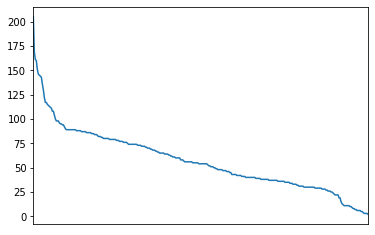

https://www.wijkbijduurstede.nl/            8
https://www.arnhem.nl/                      7
https://www.tilburg.nl/                     7
https://www.dantumadiel.frl/                6
https://www.noardeast-fryslan.nl/           6
https://www.echt-susteren.nl/               6
https://gooisemeren.nl/                     6
http://www.rozendaal.nl/                    5
https://www.baarle-nassau.nl/               5
https://www.meppel.nl/                      4
https://www.kampen.nl/                      3
https://www.opmeer.nl/                      3
https://www.papendrecht.nl/                 3
https://www.hardinxveld-giessendam.nl/      3
https://www.hofvantwente.nl/portaal.html    2
Name: top_level_url, dtype: int64

In [27]:
print(javascript_analysis_set['top_level_url'].describe())

plot = javascript_analysis_set.copy()['top_level_url'].value_counts().plot.line()
plot.axes.get_xaxis().set_visible(False)
plt.show()

javascript_analysis_set['top_level_url'].value_counts().tail(15)

In [24]:
document_cookie = javascript_analysis_set[javascript_analysis_set['symbol'] == 'window.document.cookie']
document_cookie.shape

# What abou
# window.localStorage, window.Storage.getItem, window.sessionStorage


# Helper function to get TLD+1 level of crawled link.
def parse_tld_url(url):
    return get_fld(url, fail_silently=True)

# Create a copy to the warning goes away
script_url_cookies = document_cookie.copy()

script_url_cookies['script_url_tld'] = script_url_cookies['script_url'].apply(parse_tld_url)


def top_script_url_tld(script_url_cookies):
    # Let's create a new column with the script_url stripped to top level domain
    return script_url_cookies.copy()[['script_url_tld', 'parent_url']]\
        .groupby('script_url_tld')\
        .count()\
        .sort_values(by=['parent_url'], ascending=False)\
#         .head(20)
    
top_script_url_tld(script_url_cookies).to_csv("third_party_js_script_url.csv")
top_script_url_tld(script_url_cookies)

# top_script_url_tld(script_url_cookies)
# Ok so we've got an idea of who is most prevelant in their cookie actions... 

,parent_url
script_url_tld,
google-analytics.com,3543
simanalytics.nl,1451
readspeaker.com,830
siteimproveanalytics.com,606
siteimprove.com,215
sooqr.com,147
cobrowser.com,119
livecom.net,57
hotjar.com,34


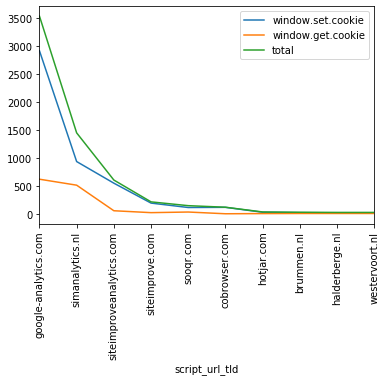

In [10]:
# For the get cookies
get_cookies = script_url_cookies.copy()
get_cookies = get_cookies[get_cookies['operation'] == 'get']
get_group = top_script_url_tld(get_cookies)

set_cookies = script_url_cookies.copy()
set_cookies = set_cookies[set_cookies['operation'] == 'set']
set_group = top_script_url_tld(set_cookies)

set_and_get = get_group.join(set_group, lsuffix='_set', rsuffix='_get')
set_and_get['total'] = set_and_get['parent_url_set'] + set_and_get['parent_url_get']
set_and_get = set_and_get.rename(index=str, columns={"parent_url_set": "window.set.cookie", "parent_url_get": "window.get.cookie"})
set_and_get.sort_values(by='total', ascending=False).head(10).plot.line()
plt.xticks(rotation=90)
plt.show()


In [32]:
# Davide graphing relationships between js proviers and gemeente
gemeente_url_js_execution_host = javascript_analysis_set.copy()
gemeente_url_js_execution_host['script_url_tld'] = gemeente_url_js_execution_host['script_url'].apply(parse_tld_url)
# gemeente_url_js_execution_host[['script_url_tld', 'parent_url']].to_csv("gemeente_url_js_execution_host.csv")
gemeente_url_js_execution_host

In [33]:
social_sites_document_cookie = script_url_cookies[script_url_cookies['script_url_tld'] == "facebook.net"]
pd.set_option('display.max_colwidth', 100)

print(social_sites_document_cookie.shape)

_fbp = social_sites_document_cookie[social_sites_document_cookie.value.str.contains('_fbp')]
_fbp

# See: Advertising, recommendations, insights and measurement
# https://www.facebook.com/policy/cookies/
# Advertising, recommendations, insights and measurement
#     We use cookies to help us show ads and to make recommendations for businesses and other organizations to 
#     people who may be interested in the products, services or causes they promote.
#
#     For example: Cookies allow us to help deliver ads to people who have previously visited 
#     a business’s website, purchased its products or used its apps and to recommend products and services 
#     based on that activity. Cookies also allow us to limit the number of times that you see an ad so you don’t 
#     see the same ad over and over again

# _fbp.to_csv("gemeente_landing_pages_with_fbp.csv")
_fbp

(24, 12)


,func_name,script_url,top_level_url,call_stack,symbol,operation,value,arguments,time_stamp,site_url,parent_url,script_url_tld
visit_id,,,,,,,,,,,,
2493,v,https://connect.facebook.net/signals/config/1684063781656834?v=2.8.47&r=stable,https://www.helmond.nl/Inwoner,v@https://connect.facebook.net/signals/config/1684063781656834?v=2.8.47&r=stable:26:18106\nx@htt...,window.document.cookie,set,"_fbp=fb.0.1557963998556.1282726948;expires=Tue, 13 Aug 2019 23:46:38 GMT;domain=.nl;path=/",None,2019-05-15T23:46:38.997Z,http://www.helmond.nl,http://www.helmond.nl,facebook.net
2493,v,https://connect.facebook.net/signals/config/1684063781656834?v=2.8.47&r=stable,https://www.helmond.nl/Inwoner,v@https://connect.facebook.net/signals/config/1684063781656834?v=2.8.47&r=stable:26:18106\nx@htt...,window.document.cookie,set,"_fbp=fb.1.1557963998556.1282726948;expires=Tue, 13 Aug 2019 23:46:38 GMT;domain=.helmond.nl;path=/",None,2019-05-15T23:46:38.997Z,http://www.helmond.nl,http://www.helmond.nl,facebook.net
2493,s,https://connect.facebook.net/signals/config/1684063781656834?v=2.8.47&r=stable,https://www.helmond.nl/Inwoner,s@https://connect.facebook.net/signals/config/1684063781656834?v=2.8.47&r=stable:26:17778\nx@htt...,window.document.cookie,get,_sce=1; _ga=GA1.2.1340102085.1557963998; _gid=GA1.2.1683937453.1557963998; _gat_UA-11787356-6=1;...,None,2019-05-15T23:46:38.998Z,http://www.helmond.nl,http://www.helmond.nl,facebook.net
2493,s,https://connect.facebook.net/signals/config/1684063781656834?v=2.8.47&r=stable,https://www.helmond.nl/Inwoner,s@https://connect.facebook.net/signals/config/1684063781656834?v=2.8.47&r=stable:26:17778\nt@htt...,window.document.cookie,get,_sce=1; _ga=GA1.2.1340102085.1557963998; _gid=GA1.2.1683937453.1557963998; _gat_UA-11787356-6=1;...,None,2019-05-15T23:46:40.183Z,http://www.helmond.nl,http://www.helmond.nl,facebook.net
2493,s,https://connect.facebook.net/signals/config/1684063781656834?v=2.8.47&r=stable,https://www.helmond.nl/Inwoner,s@https://connect.facebook.net/signals/config/1684063781656834?v=2.8.47&r=stable:26:17778\nt@htt...,window.document.cookie,get,_sce=1; _ga=GA1.2.1340102085.1557963998; _gid=GA1.2.1683937453.1557963998; _gat_UA-11787356-6=1;...,None,2019-05-15T23:46:40.184Z,http://www.helmond.nl,http://www.helmond.nl,facebook.net
2493,v,https://connect.facebook.net/signals/config/1684063781656834?v=2.8.47&r=stable,https://www.helmond.nl/Inwoner,v@https://connect.facebook.net/signals/config/1684063781656834?v=2.8.47&r=stable:26:18106\nw@htt...,window.document.cookie,set,"_fbp=fb.1.1557963998556.1282726948;expires=Tue, 13 Aug 2019 23:46:40 GMT;domain=.helmond.nl;path=/",None,2019-05-15T23:46:40.184Z,http://www.helmond.nl,http://www.helmond.nl,facebook.net
3669,v,https://connect.facebook.net/signals/config/806847392797274?v=2.8.47&r=stable,https://www.visitleiden.nl/nl/landingpage,v@https://connect.facebook.net/signals/config/806847392797274?v=2.8.47&r=stable:26:18106\nx@http...,window.document.cookie,set,"_fbp=fb.0.1557967197061.614780498;expires=Wed, 14 Aug 2019 00:39:57 GMT;domain=.nl;path=/",None,2019-05-16T00:39:57.198Z,http://www.leiden.nl,http://www.leiden.nl,facebook.net
3669,v,https://connect.facebook.net/signals/config/806847392797274?v=2.8.47&r=stable,https://www.visitleiden.nl/nl/landingpage,v@https://connect.facebook.net/signals/config/806847392797274?v=2.8.47&r=stable:26:18106\nx@http...,window.document.cookie,set,"_fbp=fb.1.1557967197061.614780498;expires=Wed, 14 Aug 2019 00:39:57 GMT;domain=.visitleiden.nl;p...",None,2019-05-16T00:39:57.199Z,http://www.leiden.nl,http://www.leiden.nl,facebook.net
3669,s,https://connect.facebook.net/signals/config/806847392797274?v=2.8.47&r=stable,https://www.visitleiden.nl/nl/landingpage,s@https://connect.facebook.net/signals/config/806847392797274?v=2.8.47&r=stable:26:17778\nx@http...,window.document.cookie,get,PHPSESSID=r4vbr4og5jao98isq4qu1uoohe; _ga=GA1.2.1439837468.1557967197; _gid=GA1.2.466017198.1557...,None,2019-05-16T00:39:57.199Z,http://www.leide

In [12]:
# What does a single one of these look like... domain... expires... path... _fbp
raw = _fbp.iloc[0].value
print(raw, "\n")
cookie = SimpleCookie()
cookie.load(raw)

# key, Morsel
introspect_cookie = [{"key": k, "Morsel": m} for k, m in cookie.items()]

# Methods on Morsel
morsel = introspect_cookie[0].get('Morsel')
print(morsel, "\n")
print(morsel.__dict__, "\n")

for k in morsel.keys():
    print(f"Key: {k}, Value: {morsel[k]}")

# So maybe we go back to the whole set and just see what kind of cookie keys are flying around?
morsel.key

_fbp=fb.0.1557963998556.1282726948;expires=Tue, 13 Aug 2019 23:46:38 GMT;domain=.nl;path=/ 

Set-Cookie: _fbp=fb.0.1557963998556.1282726948; Domain=.nl; expires=Tue, 13 Aug 2019 23:46:38 GMT; Path=/ 

{'_key': '_fbp', '_value': 'fb.0.1557963998556.1282726948', '_coded_value': 'fb.0.1557963998556.1282726948'} 

Key: expires, Value: Tue, 13 Aug 2019 23:46:38 GMT
Key: path, Value: /
Key: comment, Value: 
Key: domain, Value: .nl
Key: max-age, Value: 
Key: secure, Value: 
Key: httponly, Value: 
Key: version, Value: 


'_fbp'

In [13]:
cookie_keys = javascript_analysis_set.copy()

# The _ga cookie stores one valuable piece of information: your Client ID.
# With a default, most basic implementation, when a user arrives on your 
# website, the Google Analytics code executes and looks to see if there is a _ga cookie already present.
# https://www.bounteous.com/insights/2017/08/17/how-google-analytics-uses-cookies-identify-users/
# Does this mean it can't be used for cross site advertising?

def extract_cookie_keys(cookie_string):
    cookie = SimpleCookie()
    cookie.load(cookie_string)
    try: 
        unpacked = [{"key": k, "morsel": m} for k, m in cookie.items()]
        morsel_keys = [c.get('morsel').key for c in unpacked]
        return morsel_keys
    except Exception as e: 
        return None
    
# Add a column which contains all of the cookie keys from the javascript event row
cookie_keys['cookie_value'] = cookie_keys['value'].apply(extract_cookie_keys)

# Remove any rows that have no cookie_keys
cookie_keys = cookie_keys[cookie_keys['cookie_value'].map(lambda d: len(d)) > 0]
cookie_keys.head()

,func_name,script_url,top_level_url,call_stack,symbol,operation,value,arguments,time_stamp,site_url,parent_url,cookie_value
visit_id,,,,,,,,,,,,
6,,https://gemeente.groningen.nl/misc/drupal.js?pq7din,https://gemeente.groningen.nl/,@https://gemeente.groningen.nl/misc/drupal.js?pq7din:575:1\n@https://gemeente.groningen.nl/misc/...,window.document.cookie,set,has_js=1; path=/,None,2019-05-15T21:49:02.608Z,http://gemeente.groningen.nl,http://gemeente.groningen.nl,[has_js]
6,d.cookie,https://www.kcmsurvey.com/custom/gemeentegroningen/tevredenheidsonderzoek/gemeentegroningen.js,https://gemeente.groningen.nl/,d.cookie@https://www.kcmsurvey.com/custom/gemeentegroningen/tevredenheidsonderzoek/gemeentegroni...,window.document.cookie,set,"kcm_test=kcm_test; expires=Wed, 04 Sep 2019 21:49:00 GMT",None,2019-05-15T21:49:02.908Z,http://gemeente.groningen.nl,http://gemeente.groningen.nl,[kcm_test]
6,d.cookie,https://www.kcmsurvey.com/custom/gemeentegroningen/tevredenheidsonderzoek/gemeentegroningen.js,https://gemeente.groningen.nl/,d.cookie@https://www.kcmsurvey.com/custom/gemeentegroningen/tevredenheidsonderzoek/gemeentegroni...,window.document.cookie,get,has_js=1; kcm_test=kcm_test,None,2019-05-15T21:49:02.909Z,http://gemeente.groningen.nl,http://gemeente.groningen.nl,"[has_js, kcm_test]"
6,d.cookie,https://www.kcmsurvey.com/custom/gemeentegroningen/tevredenheidsonderzoek/gemeentegroningen.js,https://gemeente.groningen.nl/,d.cookie@https://www.kcmsurvey.com/custom/gemeentegroningen/tevredenheidsonderzoek/gemeentegroni...,window.document.cookie,get,has_js=1; kcm_test=kcm_test,None,2019-05-15T21:49:02.910Z,http://gemeente.groningen.nl,http://gemeente.groningen.nl,"[has_js, kcm_test]"
6,d.cookie,https://www.kcmsurvey.com/custom/gemeentegroningen/tevredenheidsonderzoek/gemeentegroningen.js,https://gemeente.groningen.nl/,d.cookie@https://www.kcmsurvey.com/custom/gemeentegroningen/tevredenheidsonderzoek/gemeentegroni...,window.document.cookie,get,has_js=1; kcm_test=kcm_test,None,2019-05-15T21:49:02.910Z,http://gemeente.groningen.nl,http://gemeente.groningen.nl,"[has_js, kcm_test]"


In [14]:
work_keys = cookie_keys.copy()
columns = list(work_keys.columns) + ['cookie_key']
new_cookie_keys = pd.DataFrame(columns=columns)

# How do I unstack all of this? 
# https://stackoverflow.com/questions/53218931/how-to-unnest-explode-a-column-in-a-pandas-dataframe
# My solution is NOT performant

counter = 0
print(work_keys.shape)
for index, row in work_keys.iterrows():
    counter += 1
    for k in row['cookie_value']:
        row['cookie_key'] = k
        new_cookie_keys = new_cookie_keys.append(row)
    if counter % 500 == 0:
        print(counter)

new_cookie_keys


(7200, 12)
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000


,func_name,script_url,top_level_url,call_stack,symbol,operation,value,arguments,time_stamp,site_url,parent_url,cookie_value,cookie_key
6,,https://gemeente.groningen.nl/misc/drupal.js?pq7din,https://gemeente.groningen.nl/,@https://gemeente.groningen.nl/misc/drupal.js?pq7din:575:1\n@https://gemeente.groningen.nl/misc/...,window.document.cookie,set,has_js=1; path=/,None,2019-05-15T21:49:02.608Z,http://gemeente.groningen.nl,http://gemeente.groningen.nl,[has_js],has_js
6,d.cookie,https://www.kcmsurvey.com/custom/gemeentegroningen/tevredenheidsonderzoek/gemeentegroningen.js,https://gemeente.groningen.nl/,d.cookie@https://www.kcmsurvey.com/custom/gemeentegroningen/tevredenheidsonderzoek/gemeentegroni...,window.document.cookie,set,"kcm_test=kcm_test; expires=Wed, 04 Sep 2019 21:49:00 GMT",None,2019-05-15T21:49:02.908Z,http://gemeente.groningen.nl,http://gemeente.groningen.nl,[kcm_test],kcm_test
6,d.cookie,https://www.kcmsurvey.com/custom/gemeentegroningen/tevredenheidsonderzoek/gemeentegroningen.js,https://gemeente.groningen.nl/,d.cookie@https://www.kcmsurvey.com/custom/gemeentegroningen/tevredenheidsonderzoek/gemeentegroni...,window.document.cookie,get,has_js=1; kcm_test=kcm_test,None,2019-05-15T21:49:02.909Z,http://gemeente.groningen.nl,http://gemeente.groningen.nl,"[has_js, kcm_test]",has_js
6,d.cookie,https://www.kcmsurvey.com/custom/gemeentegroningen/tevredenheidsonderzoek/gemeentegroningen.js,https://gemeente.groningen.nl/,d.cookie@https://www.kcmsurvey.com/custom/gemeentegroningen/tevredenheidsonderzoek/gemeentegroni...,window.document.cookie,get,has_js=1; kcm_test=kcm_test,None,2019-05-15T21:49:02.909Z,http://gemeente.groningen.nl,http://gemeente.groningen.nl,"[has_js, kcm_test]",kcm_test
6,d.cookie,https://www.kcmsurvey.com/custom/gemeentegroningen/tevredenheidsonderzoek/gemeentegroningen.js,https://gemeente.groningen.nl/,d.cookie@https://www.kcmsurvey.com/custom/gemeentegroningen/tevredenheidsonderzoek/gemeentegroni...,window.document.cookie,get,has_js=1; kcm_test=kcm_test,None,2019-05-15T21:49:02.910Z,http://gemeente.groningen.nl,http://gemeente.groningen.nl,"[has_js, kcm_test]",has_js
6,d.cookie,https://www.kcmsurvey.com/custom/gemeentegroningen/tevredenheidsonderzoek/gemeentegroningen.js,https://gemeente.groningen.nl/,d.cookie@https://www.kcmsurvey.com/custom/gemeentegroningen/tevredenheidsonderzoek/gemeentegroni...,window.document.cookie,get,has_js=1; kcm_test=kcm_test,None,2019-05-15T21:49:02.910Z,http://gemeente.groningen.nl,http://gemeente.groningen.nl,"[has_js, kcm_test]",kcm_test
6,d.cookie,https://www.kcmsurvey.com/custom/gemeentegroningen/tevredenheidsonderzoek/gemeentegroningen.js,https://gemeente.groningen.nl/,d.cookie@https://www.kcmsurvey.com/custom/gemeentegroningen/tevredenheidsonderzoek/gemeentegroni...,window.document.cookie,get,has_js=1; kcm_test=kcm_test,None,2019-05-15T21:49:02.910Z,http://gemeente.groningen.nl,http://gemeente.groningen.nl,"[has_js, kcm_test]",has_js
6,d.cookie,https://www.kcmsurvey.com/custom/gemeentegroningen/tevredenheidsonderzoek/gemeentegroningen.js,https://gemeente.groningen.nl/,d.cookie@https://www.kcmsurvey.com/custom/gemeentegroningen/tevredenheidsonderzoek/gemeentegroni...,window.document.cookie,get,has_js=1; kcm_test=kcm_test,None,2019-05-15T21:49:02.910Z,http://gemeente.groningen.nl,http://gemeente.groningen.nl,"[has_js, kcm_test]",kcm_test
6,d.cookie,https://www.kcmsurvey.com/custom/gemeentegroningen/tevredenheidsonderzoek/gemeentegroningen.js,https://gemeente.groningen.nl/,d.cookie@https://www.kcmsurvey.com/custom/gemeentegroningen/tevredenheidsonderzoek/gemeentegroni...,window.document.cookie,get,has_js=1; kcm_test=kcm_test,None,2019-05-15T21:49:02.911Z,http://gemeente.groningen.nl,http://gemeente.groningen.nl,"[has_js, kcm_test]",has_js
6,d.cookie,https://www.kcmsurvey.com/custom/gemeentegroningen/tevredenheidsonderzoek/gemeentegroningen.js,https://gemeente.groningen.nl/,d.cookie@https://www.kcmsurvey.com/custom/gemeentegroningen/tevredenheidsonderzoek/gemeentegroni...,w

In [15]:
# 20 most frequence cookies that were set or retrieved...
new_cookie_keys.cookie_key.value_counts().head(50)

_ga                                  2975
_gid                                 2786
nmstat                               1825
_gat                                 1390
has_js                                863
__utmz                                580
__utma                                580
__utmb                                580
__utmc                                574
__utmt                                454
__sqrc                                316
__sqrb                                316
__sqra                                316
test                                  303
_sce                                  298
_cbv                                  237
_cbs                                  228
_hjIncludedInSample                   156
ReadSpeakerSettings                    68
PHPSESSID                              68
has-visited-algemeen                   67
_pk_id.147.9b7e                        63
_pk_id.126.a52b                        62
_pk_ses.147.9b7e                  

In [49]:
new_cookie_keys['script_tld'] = new_cookie_keys['script_url'].apply(parse_tld_url)
cookie_keys_by_parent_url = new_cookie_keys.groupby('parent_url')['cookie_key'].value_counts()

# Is this skewed by the number of times we end up at any of these tlds?
cookie_keys_by_parent_url.sort_values(ascending=False)

# new_cookie_keys[new_cookie_keys['parent_url'] == "http://www.leiden.nl"]
# #These are the most popular cookie keys per parent site

new_cookie_keys[new_cookie_keys['parent_url'].str.contains("leiden")]


,func_name,script_url,top_level_url,call_stack,symbol,operation,value,arguments,time_stamp,site_url,parent_url,cookie_value,cookie_key,script_tld
3669,Ca,https://www.google-analytics.com/analytics.js,https://www.visitleiden.nl/nl/landingpage,Ca@https://www.google-analytics.com/analytics.js:19:38\nJc@https://www.google-analytics.com/anal...,window.document.cookie,get,PHPSESSID=r4vbr4og5jao98isq4qu1uoohe,None,2019-05-16T00:39:57.175Z,http://www.leiden.nl,http://www.leiden.nl,[PHPSESSID],PHPSESSID,google-analytics.com
3669,Ca,https://www.google-analytics.com/analytics.js,https://www.visitleiden.nl/nl/landingpage,Ca@https://www.google-analytics.com/analytics.js:19:38\nXc@https://www.google-analytics.com/anal...,window.document.cookie,get,PHPSESSID=r4vbr4og5jao98isq4qu1uoohe,None,2019-05-16T00:39:57.175Z,http://www.leiden.nl,http://www.leiden.nl,[PHPSESSID],PHPSESSID,google-analytics.com
3669,Jc,https://www.google-analytics.com/analytics.js,https://www.visitleiden.nl/nl/landingpage,Jc@https://www.google-analytics.com/analytics.js:58:185\npc@https://www.google-analytics.com/ana...,window.document.cookie,get,PHPSESSID=r4vbr4og5jao98isq4qu1uoohe,None,2019-05-16T00:39:57.175Z,http://www.leiden.nl,http://www.leiden.nl,[PHPSESSID],PHPSESSID,google-analytics.com
3669,ra,https://www.google-analytics.com/analytics.js,https://www.visitleiden.nl/nl/landingpage,ra@https://www.google-analytics.com/analytics.js:14:1312\nJc@https://www.google-analytics.com/an...,window.document.cookie,get,PHPSESSID=r4vbr4og5jao98isq4qu1uoohe,None,2019-05-16T00:39:57.177Z,http://www.leiden.nl,http://www.leiden.nl,[PHPSESSID],PHPSESSID,google-analytics.com
3669,ra,https://www.google-analytics.com/analytics.js,https://www.visitleiden.nl/nl/landingpage,ra@https://www.google-analytics.com/analytics.js:14:1312\nJc@https://www.google-analytics.com/an...,window.document.cookie,get,PHPSESSID=r4vbr4og5jao98isq4qu1uoohe,None,2019-05-16T00:39:57.177Z,http://www.leiden.nl,http://www.leiden.nl,[PHPSESSID],PHPSESSID,google-analytics.com
3669,ra,https://www.google-analytics.com/analytics.js,https://www.visitleiden.nl/nl/landingpage,ra@https://www.google-analytics.com/analytics.js:14:1312\nJc@https://www.google-analytics.com/an...,window.document.cookie,get,PHPSESSID=r4vbr4og5jao98isq4qu1uoohe,None,2019-05-16T00:39:57.180Z,http://www.leiden.nl,http://www.leiden.nl,[PHPSESSID],PHPSESSID,google-analytics.com
3669,ra,https://www.google-analytics.com/analytics.js,https://www.visitleiden.nl/nl/landingpage,ra@https://www.google-analytics.com/analytics.js:14:1312\nJc@https://www.google-analytics.com/an...,window.document.cookie,get,PHPSESSID=r4vbr4og5jao98isq4qu1uoohe,None,2019-05-16T00:39:57.180Z,http://www.leiden.nl,http://www.leiden.nl,[PHPSESSID],PHPSESSID,google-analytics.com
3669,G,https://www.google-analytics.com/analytics.js,https://www.visitleiden.nl/nl/landingpage,G@https://www.google-analytics.com/analytics.js:18:859\nzc@https://www.google-analytics.com/anal...,window.document.cookie,get,PHPSESSID=r4vbr4og5jao98isq4qu1uoohe,None,2019-05-16T00:39:57.181Z,http://www.leiden.nl,http://www.leiden.nl,[PHPSESSID],PHPSESSID,google-analytics.com
3669,zc,https://www.google-analytics.com/analytics.js,https://www.visitleiden.nl/nl/landingpage,zc@https://www.google-analytics.com/analytics.js:19:457\nma@https://www.google-analytics.com/ana...,window.document.cookie,get,PHPSESSID=r4vbr4og5jao98isq4qu1uoohe,None,2019-05-16T00:39:57.182Z,http://www.leiden.nl,http://www.leiden.nl,[PHPSESSID],PHPSESSID,google-analytics.com
3669,zc,https://www.google-analytics.com/analytics.js,https://www.visitleiden.nl/nl/landingpage,zc@https://www.google-analytics.com/analytics.js:19:468\nma@https://www.google-analytics.com/ana...,window.document.cookie,set,"_ga=GA1.2.1439837468.1557967197; path=/; expires=Sat, 15 May 2021 00:39:56 GMT; domain=visitleid...",None,2019-05-16T00:39:57.183Z,http://www.leiden.nl,http://www.leiden.nl,[_ga],_ga,google-analytics.com


In [17]:
cookie_keys_by_script_url = new_cookie_keys.groupby('script_tld')['cookie_key'].value_counts()
cookie_keys_by_script_url.sort_values(ascending=False).head(50)

#This is where most of the scripts come from...

script_tld                cookie_key          
google-analytics.com      _ga                     1885
                          _gid                    1696
                          _gat                     682
                          nmstat                   606
                          __utma                   380
                          __utmb                   380
                          __utmz                   380
                          __utmc                   374
                          has_js                   371
siteimproveanalytics.com  nmstat                   334
simanalytics.nl           test                     300
readspeaker.com           nmstat                   268
google-analytics.com      __utmt                   254
siteimproveanalytics.com  _gid                     193
                          _ga                      193
simanalytics.nl           nmstat                   189
readspeaker.com           _gid                     185
                  